# Explainable AI

This workshop will focus on explaining the outcomes of a predictive analytics model.  
  
We provide similar explanation for two cases: 1) regression with Toyota Corolla Car Prices Dataset, and 2) classification with Titanic dataset.  

For each of the case study, we will use advanced explanation methods using SHAP framework.

Install python library for SHAP explainer toolbox.  
Documentation URL: https://shap.readthedocs.io/en/latest/

In [111]:
# Install python library for SHAP explainer toolbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install python library for LIME explainer toolbox.  
Documentation URL: https://github.com/marcotcr/lime

In [112]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load common libraries for data wrangling.

In [113]:
# Load required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

## Regression

Load the dataset file to a dataframe using Pandas library.

In [114]:
df = pd.read_csv('tp4_toyota_corolla.csv')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


**Data Description**
* Price: Price in EUROs  
* Age: Age in years  
* KM: Accumulated Kilometers on odometer  
* FuelType: Fuel Type (Petrol, Diesel, CNG)  
* HP: Horse Power  
* MetColor: Metallic Color? (Yes=1, No=0)  
* Automatic: Automatic ( (Yes=1, No=0)  
* CC: Cylinder Volume in cubic centimeters  
* Doors: Number of doors  
* Weight: Weight in Kilograms  

In [116]:
df.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


The dataset contains one categorical variable (FuelType). For the demonstration we will ignore this column.   
Exercise: Recall 'Categorical variable transformation' techniques you learned for BUS5PA. Transofrm FuelType variable and run the experiment again. Evaluate if you can improve the accuracy.

In [117]:
# Setup train and test data
df_x = df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']]
df_y = df[['Price']]

This dataset contains 506 data points. Therefore, we could select data split as train/validation as 70/30 (we will not be using test data split)

In [118]:
X_train, X_val, Y_train, Y_val = train_test_split(df_x, df_y, test_size = 0.3, random_state = 5)

### Modeling

Train a simple linear regression model

In [119]:
from sklearn import linear_model

# Model
reg_model = linear_model.LinearRegression()
reg_model.fit(X_train,Y_train)

# Predict
Y_val_predict = reg_model.predict(X_val)

# Evaluate
error_val = np.sqrt(mean_squared_error(Y_val_predict, Y_val))
print('Validation Root Mean Squared Error (Linear regression): ' + str(error_val))

Validation Root Mean Squared Error (Linear regression): 1306.5645389387585


Train an advanced Gradient boosting regression model

In [120]:
from xgboost import XGBRegressor

gbr_model = XGBRegressor()
gbr_model.fit(X_train, Y_train)

# Predict
Y_val_predict = gbr_model.predict(X_val)

# Evaluate
error_val = np.sqrt(mean_squared_error(Y_val_predict, Y_val))
print('Validation Root Mean Squared Error (Gradient Boosting): ' + str(error_val))

Validation Root Mean Squared Error (Gradient Boosting): 1159.640330305863


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### SHAP Explainer

In [121]:
# import shap library
import shap

Create a shap explainer from gradient boosting model

In [122]:
explainer = shap.TreeExplainer(gbr_model)
shap_values = explainer.shap_values(X_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Explain individual train (or test) data points on their contribution to the outcome.  
The below visualization shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [123]:
record_id = 73

print('Actual values:')
print(X_train.iloc[record_id,:])

# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[record_id,:], X_train.iloc[record_id,:])

Actual values:
Age             42
KM           61300
HP              97
MetColor         1
Automatic        0
CC            1400
Doors            3
Weight        1030
Name: 232, dtype: int64


Force plot can be better explain using the waterfall plot

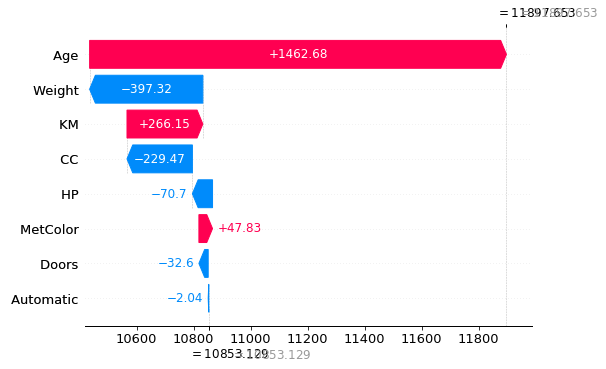

In [124]:
# visualize the prediction of given record id
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[record_id], features = X_train.iloc[record_id,:])

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [125]:
# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


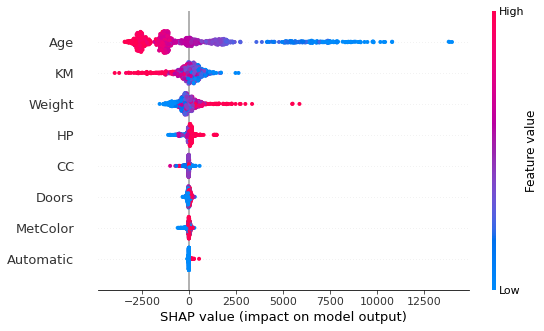

In [126]:
# summarize the effects of all the features
shap.initjs()
shap.summary_plot(shap_values, X_train)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).

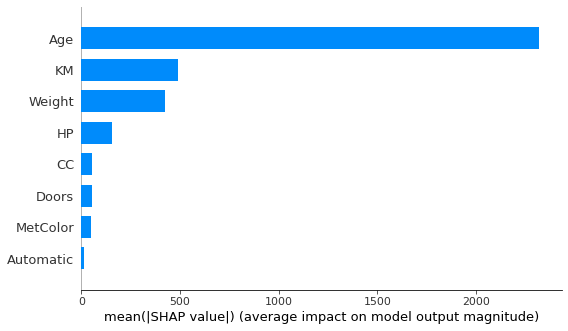

In [127]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar")

The dependence scatter plot can used to analyse the effect of a single feature across the dataset aginst a selected feature

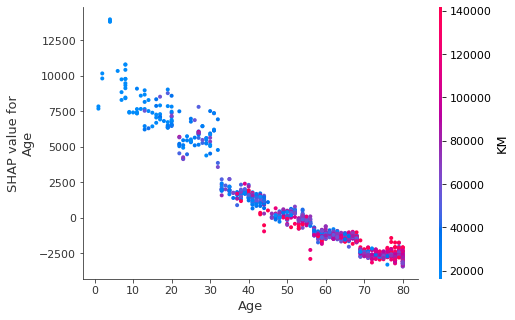

In [128]:
shap.dependence_plot('Age', shap_values, X_train, interaction_index="KM")

## Classification

In [129]:
# Load the dataset directly
df_titanic = pd.read_csv('tp3_titanic_data.csv')  # Load the dataset

In [130]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


For this tutorial we only consider integer/numeric predictors for explanation.  
Exercise: You are expected to conduct feature engineering as we demonstrated in tutorial 3, and redo the XAI as follows.

In [131]:
df_titanic_x = df_titanic[['Pclass', 'Age', 'Fare', 'SibSp']]
df_titanic_y = df_titanic[['Survived']]

In [132]:
# Fill missing values in Age
df_titanic_x['Age'].fillna((df_titanic_x['Age'].mean()), inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [133]:
X_titanic_train, X_titanic_val, Y_titanic_train, Y_titanic_val = train_test_split(df_titanic_x, df_titanic_y, test_size = 0.3, random_state = 5)

### Modeling 

We will model a simple logistic regression as the initial step.

In [134]:
from xgboost import XGBClassifier

# Modeling
gbc_model = XGBClassifier()
gbc_model.fit(X_titanic_train,Y_titanic_train)

# Classification
Y_titanic_val_predict = gbc_model.predict(X_titanic_val)

# Evaluate
accuracy = accuracy_score(Y_titanic_val_predict, Y_titanic_val)
print('Accuracy: ' + str(accuracy))

[02:44:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7089552238805971


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### SHAP Explainer

In [135]:
import shap

Create a shap explainer from gradient boosting model

In [136]:
explainer = shap.TreeExplainer(gbc_model)
shap_values = explainer.shap_values(X_titanic_train)

Explain individual test data points on their contribution to the outcome.  
The below visualization shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [137]:
record_id = 4

print('Actual values:')
print(X_titanic_train.iloc[record_id,:])

# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[record_id,:], X_titanic_train.iloc[record_id,:])

Actual values:
Pclass     1.0
Age       45.5
Fare      28.5
SibSp      0.0
Name: 331, dtype: float64


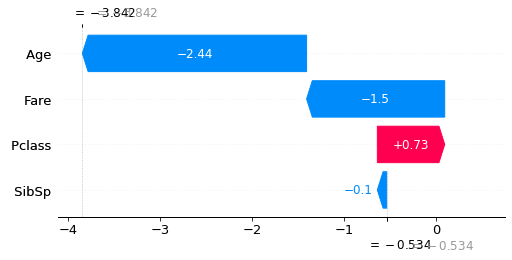

In [138]:
# visualize the prediction of given record id
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[record_id], features = X_titanic_train.iloc[record_id,:])

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [139]:
# Looks like Google Colab needs shap.initjs() in every cell where there is a visualization.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_titanic_train)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


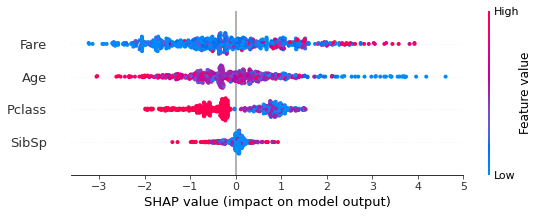

In [140]:
# summarize the effects of all the features
shap.initjs()
shap.summary_plot(shap_values, X_titanic_train)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).

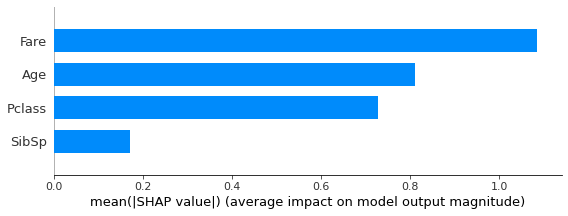

In [141]:
shap.initjs()
shap.summary_plot(shap_values, X_titanic_train, plot_type="bar")

Analysing impact of the passenger class and the fare value

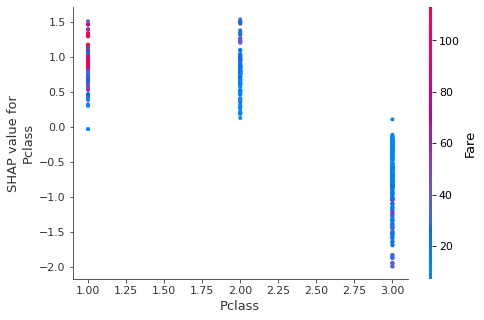

In [145]:
shap.dependence_plot('Pclass', shap_values, X_titanic_train, interaction_index="Fare")